# Computing the projection of $\mathbb{Z}$ onto $\mathcal{X}_N$
We begin by defining two sets. A polytope $\mathbb{Z}$ is usually defined as
$$
	\mathbb{Z}\coloneqq\left\{(x, \boldsymbol{u}) \in \R^n \times \R^{Nm} \mid G x + H \boldsymbol{u} + \psi \leq 0 \right\},
$$
where $G \in \R^{s \times n}$, $H \in \R^{s \times Nm}$ and $\psi \in \R^s$. We are interested in the projection of $\mathbb{Z}$ onto $\R^n$, i.e.,
$$
\mathcal{X}_N\coloneqq \left\{x \in \R^n \mid \exists u \in \R^{Nm} \text{ s.t. } (x, \boldsymbol{u}) \in \mathbb{Z} \right\}.
$$ 

Consider the discrete-time linear system
$$
	x(k+1) = \left[\begin{array}{cc}
	1 & 1\\
	0 & 1\\
	\end{array}\right] x(k) + \left[\begin{array}{c}
	0\\
	1
	\end{array} 
	\right] u(k),
$$
subjecting to state constraints $\mathbb{X} \coloneqq \left\{x \in \R^2 \mid x_1 \leq 2 \right\}$ and input constraints $\mathbb{U} \coloneqq \left\{u \in \R \mid |u| \leq 1 \right\}$. Let us consider the MPC problem with $N = 2$, such that $\boldsymbol{u} = \left[ u(0), u(1) \right]^\top$.

We are now interested in **the set of states from which there exists an admissible control sequence that ensures a feasible trajectory over $N$ steps**. First, we want to find $G$, $H$ and $\psi$ such that
$$
\begin{aligned}
	\mathbb{Z} \coloneqq \left\{\left(x, \boldsymbol{u}\right) \mid x(0), x(1), x(2) \in \mathbb{X},\; u(0), u(1) \in \mathbb{U}\right\}  = \left\{x(0) \in \R^n \mid \exists \boldsymbol{u} \in \R^{Nm} \text{ s.t. } (x(0), \boldsymbol{u}) \in \mathbb{Z} \right\}.
\end{aligned}
$$

In [1]:
import numpy as np
from utils import gen_prediction_matrices

# Dynamics matrices
Ad = np.array([
    [1., 1.],
    [0., 1.]
])
Bd = np.array([
    [0.],
    [1.]
])
N = 2
dim_x = Ad.shape[0]
dim_u = Bd.shape[1]

T, S = gen_prediction_matrices(Ad, Bd, N)
print(f"T:\n {T}")
print(f"S:\n {S}")

# T = np.array([
#     [1., 0.],
#     [0., 1.],
#     [1., 1.],
#     [0., 1.],
#     [1., 2.],
#     [0., 1.],
# ])
# S = np.array([
#     [0., 0.],
#     [0., 0.],
#     [0., 0.],
#     [1., 0.],
#     [1., 0.],
#     [1., 1.],
# ])

A = np.array([
    [1., 0.]
])
b = np.array([2.])
C = np.array([[1.], [-1.]])
d = np.ones((2, 1))

A_bar = np.kron(np.eye(N + 1), A)
b_bar = np.kron(np.ones((N + 1, 1)), b)
C_bar = np.kron(np.eye(N), C)
d_bar = np.kron(np.ones((N, 1)), d)

G = A_bar @ T
G = np.vstack([G, np.zeros((C_bar.shape[0], dim_x))])
H = np.vstack((A_bar @ S, C_bar))
psi = -np.vstack((b_bar, d_bar))

print(f"G:\n {G}")
print(f"H:\n {H}")
print(f"psi:\n {psi}")


T:
 [[1. 0.]
 [0. 1.]
 [1. 1.]
 [0. 1.]
 [1. 2.]
 [0. 1.]]
S:
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [1. 0.]
 [1. 0.]
 [1. 1.]]
G:
 [[1. 0.]
 [1. 1.]
 [1. 2.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
H:
 [[ 0.  0.]
 [ 0.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [-1. -0.]
 [ 0.  1.]
 [-0. -1.]]
psi:
 [[-2.]
 [-2.]
 [-2.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]]


Next, we compute $\mathcal{X}_2 \coloneqq \left\{x(0) \in \R^2 \mid \exists \boldsymbol{u} \in \R^2 \text{ s.t. } (x(0), \boldsymbol{u}) \in \mathbb{Z} \right\} = \left\{x(0) \in \R^2 \mid P x(0) + \gamma \leq 0 \right\}$ by iteratively elimiating control inputs. This method is known as Fourier–Motzkin elimination (https://en.wikipedia.org/wiki/Fourier%E2%80%93Motzkin_elimination).

In [11]:
def remove_zero_rows(A, b):
    """
    Removes rows of A that are all zeros and the corresponding elements in b.
    """
    keeprows = np.any(A, axis=1)
    A = A[keeprows, :]
    b = b[keeprows]
    
    return A, b 

def proj_single_input(G, H, psi):
    # Define the sets by basing on the i-th column of H
   
    I_0 = np.where(H == 0)[0]
    I_p = np.where(H > 0)[0]
    I_m = np.where(H < 0)[0]

    # Set the row of matrix [P gamma]

    # Define C    
    C = np.hstack((G, psi))

    # Define row by row [P gamma]
    aux = []
    for i in I_0:
        aux.append(C[i])

    for i in I_p:
        for j in I_m:
            aux.append(H[i]*C[j] - H[j]*C[i])

    # Return the desired matrix/vector
    aux = np.array(aux)
    P = aux[:,:-1]
    gamma = aux[:,[-1]]
    
    P, gamma = remove_zero_rows(P, gamma)

    return P, gamma

def proj_input(G, H, psi, N, dim_u):
    G_i = np.hstack((G, H[:,:-1]))
    H_i = H[:,-1]
    psi_i = psi

    for i in range(N * dim_u, 0, -1):
        P_i, gamma_i = proj_single_input(G_i, H_i, psi_i)

        G_i = P_i[:,:-1]
        H_i = P_i[:,-1]
        psi_i = gamma_i

    return P_i, gamma_i


P, gamma = proj_input(G, H, psi, N, dim_u)

# print(f"P:\n {P}")
# print(f"gamma:\n {gamma}")

Note that the representation of the set may contain redundant constraints, which should be removed to improve efficiency for future use.

# Terminal constraint and region of attraction

Consider the discrete-time linear system
$$
x(k+1) = \left[\begin{array}{cc}
2 & 1\\
0 & 2\\
\end{array}\right] x(k) + \left[\begin{array}{cc}
1&0\\
0&1
\end{array} 
\right] u(k),
$$
subject to state constraints $\mathbb{X} \coloneqq \left\{x \in \R^2 \mid x_1 \leq 5 \right\}$ and input constraints $\mathbb{U} \coloneqq \left\{u \in \R^2 \mid -\boldsymbol{1}_2 \leq u \leq \boldsymbol{1}_2  \right\}$. Consider the following cost function with terminal penalty on the final state, $V_{ \textup{f} }(x(N))$,
$$
V(x(0),\boldsymbol{u})=\frac{1}{2}\sum_{k=0}^{N-1}  x(k)^\top Q x(k)+u(k)^\top R u(k) + V_{ \textup{f} }(x(N)),
$$
where $x(0) = x_0 = [0.5, \, 0.5]^\top$, $Q = \alpha I_2$ and $R = I_2$.

- Set $N = 3$ and implement the MPC with no terminal cost ($V_{ \textup{f}}(x(N)) = 0$) for $\alpha = 0.2$.

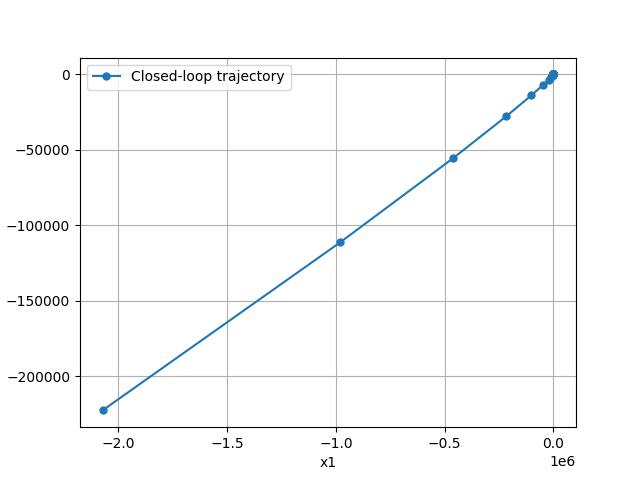

In [12]:
import numpy as np
from utils import solve_condensed_mpc

A = np.array([
    [2., 1.],
    [0., 2.]
])
B = np.eye(2)
x0 = np.array([0.5, 0.5])
N = 3
dim_x = A.shape[0]
dim_u = B.shape[1]

alpha = 0.2
Q = alpha * np.eye(2)
R = np.eye(2)
P = np.zeros((2, 2))

u_lb = np.array([-1., -1.])
u_ub = np.array([ 1.,  1.])
D = np.array([[1., 0.], [0., 0.]])
c_lb = np.array([-np.inf, -np.inf])
c_ub = np.array([5.,       np.inf])

N_sim = 30
x_hist = np.zeros((N_sim + 1, dim_x))
u_hist = np.zeros((N_sim, dim_u))
x_hist[0, :] = x0

for t in range(N_sim):
    x_bar, u_bar = solve_condensed_mpc(x_hist[t, :], A, B, Q, R, P, N, u_lb, u_ub, D, c_lb, c_ub)
    x_hist[t + 1, :] = A @ x_hist[t, :] + B @ u_bar[0, :]
    u_hist[t, :] = u_bar[0, :]
    
%matplotlib ipympl
import matplotlib.pyplot as plt

plt.figure()
plt.plot(x_hist[:, 0], x_hist[:, 1], '-o', label='Closed-loop trajectory', markersize=5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid()
plt.show()

- Implement the MPC with terminal equality constraint $x(N) = 0$ for $\alpha = 0.2$.

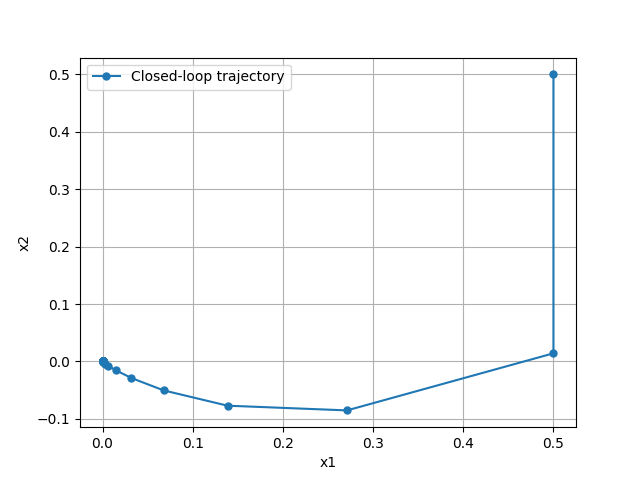

In [13]:
N_sim = 30
x_hist = np.zeros((N_sim + 1, dim_x))
u_hist = np.zeros((N_sim, dim_u))
x_hist[0, :] = x0

for t in range(N_sim):
    x_bar, u_bar = solve_condensed_mpc(x_hist[t, :], A, B, Q, R, P, N, u_lb, u_ub, D, c_lb, c_ub, with_terminal_constraint=True)
    x_hist[t + 1, :] = A @ x_hist[t, :] + B @ u_bar[0, :]
    u_hist[t, :] = u_bar[0, :]

plt.figure()  
plt.plot(x_hist[:, 0], x_hist[:, 1], '-o', label='Closed-loop trajectory', markersize=5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid()
plt.show()

 - Find the region of attraction for the constrained MPC controller using the projection algorithm.

In [17]:
import numpy as np
from utils import gen_prediction_matrices
import scipy as sp

# Dynamics matrices
A = np.array([
    [2., 1.],
    [0., 2.]
])
B = np.eye(2)
N = 3
dim_x = A.shape[0]
dim_u = B.shape[1]
u_lb = np.array([-1., -1.])
u_ub = np.array([ 1.,  1.])

T, S = gen_prediction_matrices(A, B, N)

Gx = np.array([
    [1., 0.]
])
gx = np.array([5.])
Gx_bar = np.kron(np.eye(N), Gx)
gx_bar = np.kron(np.ones(N), gx)

Gx_bar = sp.linalg.block_diag(Gx_bar, 
                              np.vstack((np.eye(dim_x), -np.eye(dim_x)))
)
gx_bar = np.hstack((gx_bar, np.zeros(2 * dim_x)))

Iu = np.eye(dim_u)
Gu = np.vstack((Iu, -Iu))
gu = np.hstack((u_ub, -u_lb))

Gu_bar = np.kron(np.eye(N), Gu)
gu_bar = np.kron(np.ones(N), gu)

G = Gx_bar @ T
G = np.vstack([G, np.zeros((Gu_bar.shape[0], dim_x))])
H = np.vstack((Gx_bar @ S, Gu_bar))
psi = -np.hstack((gx_bar, gu_bar))
psi = psi.reshape((-1, 1))  # TODO:
P, gamma = proj_input(G, H, psi, N, dim_u)

# print(f"P:\n {P}")
# print(f"gamma:\n {gamma}")

Plot the region of attraction

In [15]:
from scipy.spatial import ConvexHull
from scipy.spatial import HalfspaceIntersection
import numpy as np

halfspaces = np.hstack((P, gamma))
feasible_point = np.array([0., 0.])
hs = HalfspaceIntersection(halfspaces, feasible_point)
hull = ConvexHull(hs.intersections)


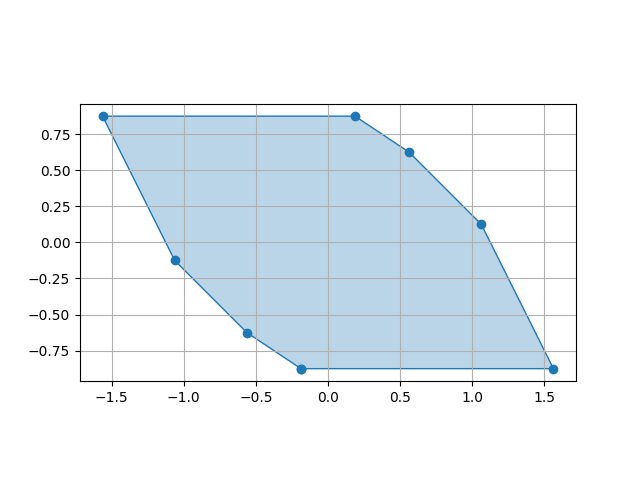

In [16]:
import matplotlib.pyplot as plt
import shapely.plotting
from shapely.geometry import Polygon

polygon1 = Polygon(hs.intersections[hull.vertices])

plt.figure()
shapely.plotting.plot_polygon(polygon1)
plt.show()